In [32]:
import os
TEST_DIR = "../test-data"

In [33]:
def generate_test_schema():
    """
    [
        {
            'document_file': 'TEST1.pdf',
            'json_file': 'TEST1.json'
        }
    ]
    """
    test_schema = []
    for root, dirs, files in os.walk(TEST_DIR):

        document_files = [f for f in files if f.endswith('.pdf')]
        actual_files = [f for f in files if f.endswith('.json')]
        assert(len(document_files) == len(actual_files))

        test_schema = [
            {
                "document_file": document_files[i],
                "json_file": actual_files[i]
            } for i in range(0, len(document_files))
        ]
    return test_schema

AVG ACCURACY: 1.0
AVG PRECISION: 1.0
AVG RECALL: 1.0
AVG F1 SCORE: 1.0


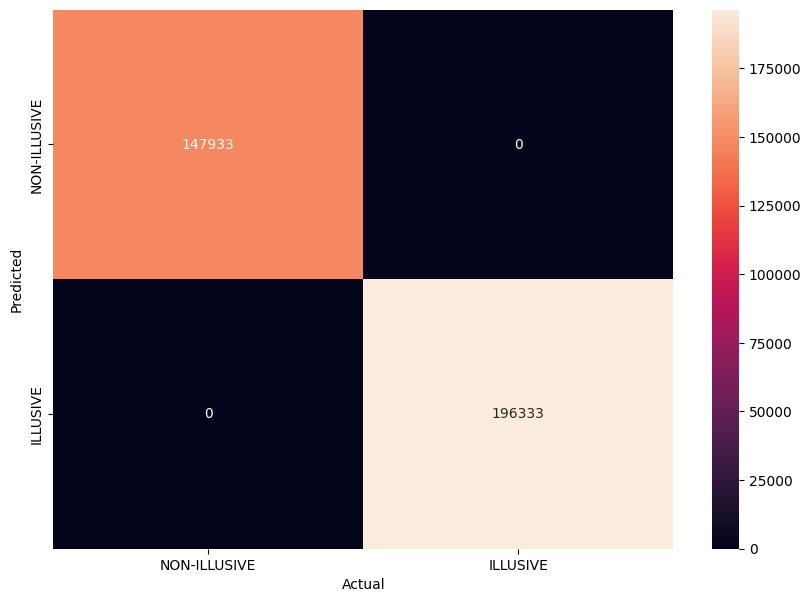

In [34]:
import json
from charset_normalizer import detect
from illusive_text_detector import IllusiveTextDetector
import sklearn.metrics as metrics
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def test_detector():
    detector = IllusiveTextDetector()
    test_schema = generate_test_schema()
    
    sum_conf_matrix = [[0, 0], [0, 0]]
    sum_acc = 0
    sum_prec = 0
    sum_recall = 0
    sum_f1 = 0

    for test in test_schema:
        test_pdf_loc = f"{TEST_DIR}/{test['document_file']}"
        test_json_loc = f"{TEST_DIR}/{test['json_file']}"

        test_json_file = open(test_json_loc)
        actual = json.load(test_json_file)
        test_json_file.close()

        predicted = detector.detect(test_pdf_loc)
        assert(actual["total_characters"] == predicted["total_characters"])

        actual_labels = []
        pred_labels = []
        for i in range(0, actual["total_characters"]):
            actual_data = actual["chars_data"][i]
            pred_data = predicted["chars_data"][i]
            assert(actual_data["char"] == pred_data["char"])
            
            actual_labels.append(actual_data["label"])
            pred_labels.append(pred_data["label"])

        sum_conf_matrix += metrics.confusion_matrix(actual_labels, pred_labels)
        sum_acc += metrics.accuracy_score(actual_labels, pred_labels)
        sum_prec += metrics.precision_score(actual_labels, pred_labels, average="binary", pos_label="ILLUSIVE")
        sum_recall += metrics.recall_score(actual_labels, pred_labels, average="binary", pos_label="ILLUSIVE")
        sum_f1 += metrics.f1_score(actual_labels, pred_labels, average="binary", pos_label="ILLUSIVE")

        # doc: fitz.Document = fitz.open(test_pdf_loc)
        # print("----")
        # print("---")
        # for p in predicted["characters_info"]:
        #     print(p['char'], end="")
        # print("\n***")
        # for a in actual["characters_info"]:
        #     print(a['char'], end="")
        # print("\n---")
        # print(predicted["characters_info"].__len__(), actual["characters_info"].__len__())
        # print("----")
    total_docs = test_schema.__len__()
    print("AVG ACCURACY:", sum_acc / total_docs)
    print("AVG PRECISION:", sum_prec / total_docs)
    print("AVG RECALL:", sum_recall / total_docs)
    print("AVG F1 SCORE:", sum_f1 / total_docs)

    classes = ["NON-ILLUSIVE", "ILLUSIVE"]
    df_cfm = pd.DataFrame(sum_conf_matrix, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='').set(xlabel='Actual', ylabel='Predicted')
test_detector()